# Heart Disease Risk Estimation

## Introduction

### Data

The goal of this project is generating a model to estimate the risk of having a heart disease. [The UCI heart disease database](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) contains 76 attributes, but all published experiments refer to using a subset of 14 of them. The target variable is an integer valued from 0 (no presence) to 4. However, for sake of simplicity, this will be reduced to a binary prediction, i.e, heart disease vs no heart disease. The dataset was collected from the four following locations:

1. Cleveland Clinic Foundation (cleveland.data)
2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
4. University Hospital, Zurich, Switzerland (switzerland.data)

Each database has the same instance format.  While the databases have 76 raw attributes, only 14 of them are actually used.

*The authors of the databases: Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.*

### Flow

[Data fetching](#data-fetching) --> [Wrangling](#wrangling) --> [Data analysis]() --> [Modeling]() --> [evaluation]()

## Python imports

In [26]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm 

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data fetching

In [27]:
link_cleveland = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
link_hungarian = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
link_swiss = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data'
link_veniceb = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'

links = [link_cleveland, link_hungarian, link_swiss, link_veniceb]
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.concat(map(lambda x: pd.read_csv(x, names=names), links))

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67.0,1.0,4.0,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67.0,1.0,4.0,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37.0,1.0,3.0,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41.0,0.0,2.0,130,204,0,2,172,0,1.4,1,0.0,3.0,0


## Wrangling

### Handling missing values

In [28]:
df.replace('?', np.nan, inplace=True)
df.isnull().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [29]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop = True, inplace = True)

### Correcting data formats

In [30]:
df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')
df[['age', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'slope', 'thal']] = df[['age', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'slope', 'thal']].astype(int)
df[['trestbps', 'chol', 'thalach', 'oldpeak']] = df[['trestbps', 'chol', 'thalach', 'oldpeak']].astype(float)
df['target'].replace(to_replace=[1, 2, 3, 4], value=1, inplace=True)

## Exploritory data analysis

### Target

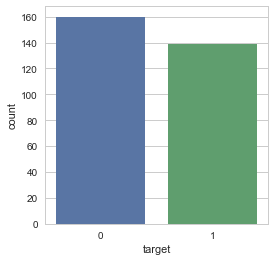

In [31]:
fig_target, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.countplot(x='target', data=df, ax=axes)

### Categorial

In [32]:
def plotCategorial(attribute):
    fig_cp, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    sns.countplot(x=attribute, data=df, ax=axes[0])
    sns.countplot(x='target', hue=attribute, data=df, ax=axes[1])
    avg = df[[attribute, 'target']].groupby([attribute], as_index=False).mean()
    sns.barplot(x=attribute, y='target', hue=attribute, data=avg, ax=axes[2])

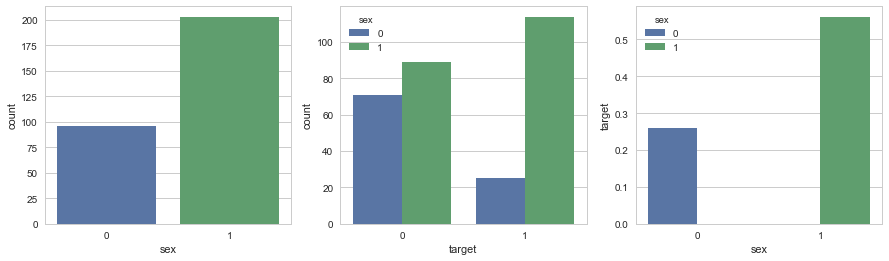

In [33]:
plotCategorial('sex')

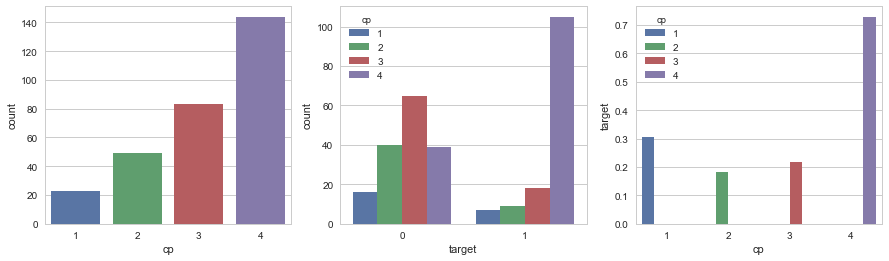

In [34]:
plotCategorial('cp')

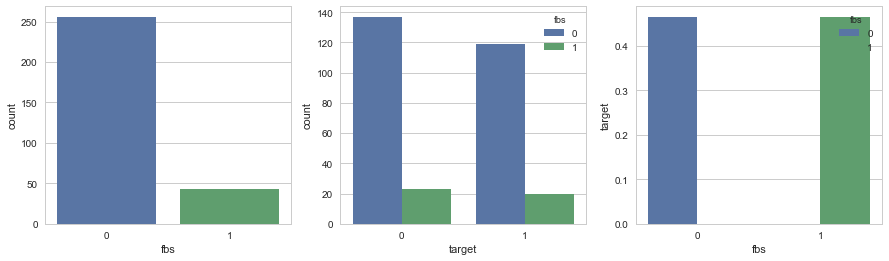

In [35]:
plotCategorial('fbs')

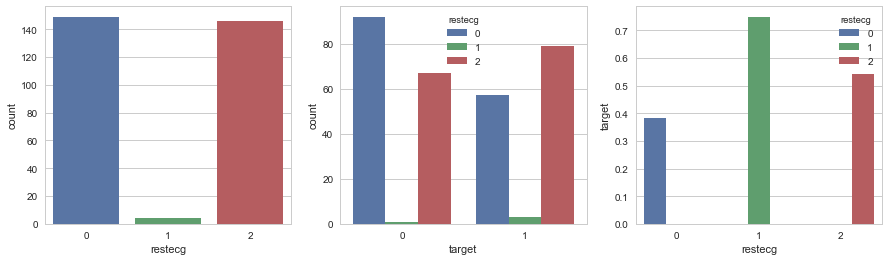

In [36]:
plotCategorial('restecg')

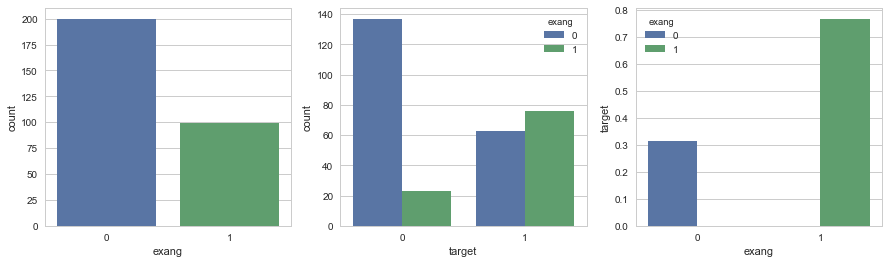

In [37]:
plotCategorial('exang')

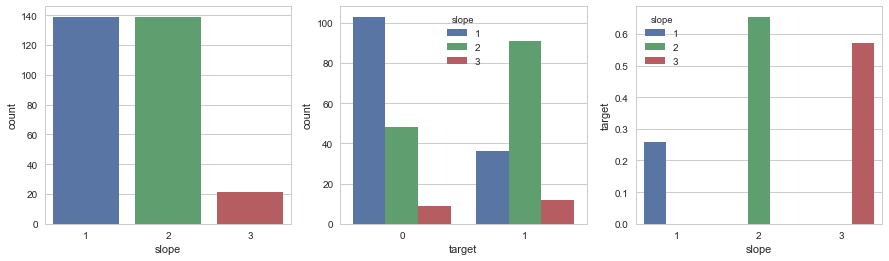

In [38]:
plotCategorial('slope')

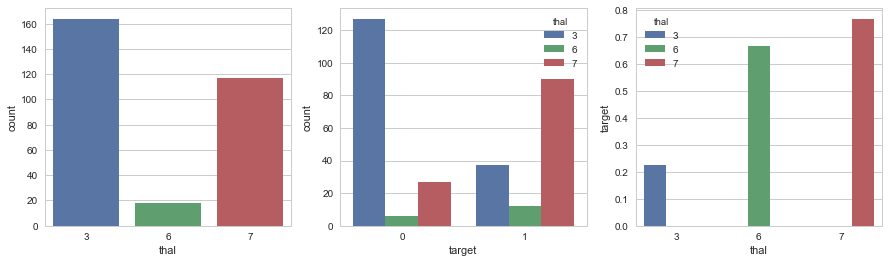

In [39]:
plotCategorial('thal')

### Continuous

In [40]:
def plotContinuous(attribute, ax_index):
    sns.distplot(df[[attribute]], ax=axes[ax_index][0])                                   
    sns.violinplot(x='target', y=attribute, data=df, ax=axes[ax_index][1])

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

[None, None, None, None, None]

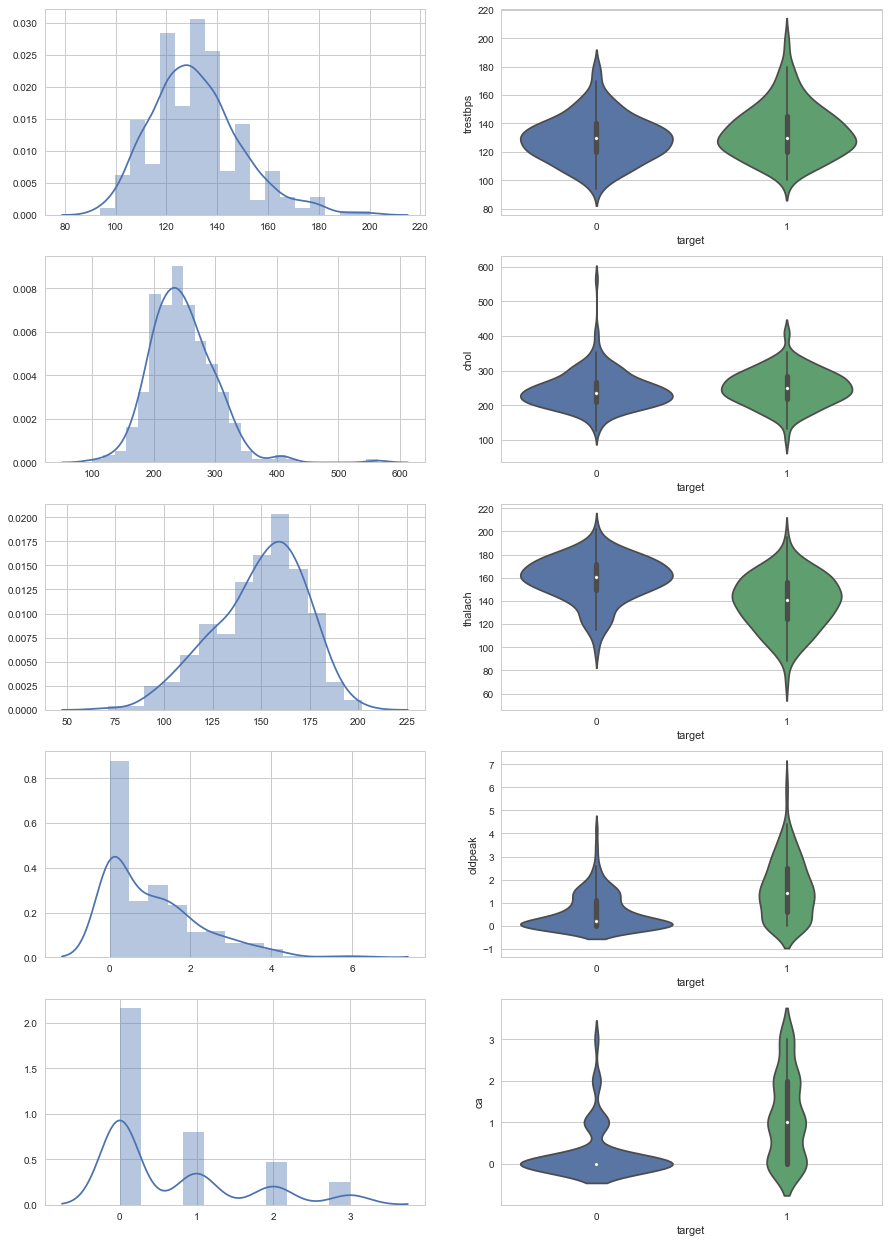

In [41]:
continuous = ['trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
fig_continuous, axes = plt.subplots(nrows=len(continuous), ncols=2, figsize=(15, 22))
[plotContinuous(x, i) for i, x in enumerate(continuous)] 

#### Age

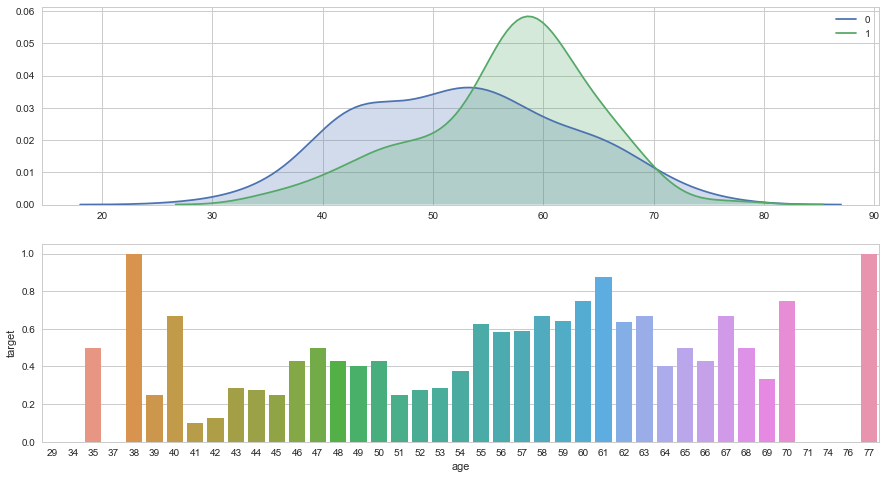

<Figure size 216x216 with 0 Axes>

In [42]:
fig_age, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
facet_grid = sns.FacetGrid(df, hue='target')
facet_grid.map(sns.kdeplot, "age", shade=True, ax=axes[0])
avg = df[["age", "target"]].groupby(['age'], as_index=False).mean()
sns.barplot(x='age', y='target', data=avg, ax=axes[1])
plt.clf()

## Finalize data for modeling

### Dummy variables

In [43]:
cp_dummy = pd.get_dummies(df['cp'])
cp_dummy.rename(columns={1: 'cp_typical_angina', 2: 'cp_atypical_angina',
                         3: 'cp_non_angina', 4: 'cp_asymptomatic_angina'},
                inplace=True)
restecg_dummy = pd.get_dummies(df['restecg'])
restecg_dummy.rename(columns={0: 'restecg_normal', 1: 'restecg_wave_abnorm',
                              2: 'restecg_ventricular_ht'}, inplace=True)
slope_dummy = pd.get_dummies(df['slope'])
slope_dummy.rename(columns={1: 'slope_upsloping', 2: 'slope_flat',
                            3: 'slope_downsloping'}, inplace=True)
thal_dummy = pd.get_dummies(df['thal'])
thal_dummy.rename(columns={3: 'thal_normal', 6: 'thal_fixed_defect',
                           7: 'thal_reversible_defect'}, inplace=True)
df = pd.concat([df, cp_dummy, restecg_dummy, slope_dummy, thal_dummy], axis=1)
df.drop(['cp', 'restecg', 'slope', 'thal'], axis=1, inplace=True)

### Separate target

In [44]:
df_X = df.drop('target', axis=1)
df_y = df['target']

### Feature selection

In [45]:
rfe = RFE(LogisticRegression())
rfe.fit(df_X.values, df_y.values)
selected_features = []

for i, col in enumerate(df_X.columns.values):
    if rfe.support_[i]:
        selected_features.append(col)

selected_X = df_X[selected_features]
selected_y = df_y

lm = sm.Logit(selected_y, selected_X)
result = lm.fit()

print result.summary()

Optimization terminated successfully.
         Current function value: 0.343469
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  299
Model:                          Logit   Df Residuals:                      288
Method:                           MLE   Df Model:                           10
Date:                Sat, 07 Jul 2018   Pseudo R-squ.:                  0.5027
Time:                        14:23:42   Log-Likelihood:                -102.70
converged:                       True   LL-Null:                       -206.51
                                        LLR p-value:                 4.122e-39
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
sex                        1.1754      0.467      2.519      0.012       0.261      

In [46]:
selected_X_train, selected_X_test, selected_y_train, selected_y_test = split(selected_X, selected_y, test_size=0.3, random_state=0)

## Modeling

### Logistic regression

In [47]:
lr = LogisticRegression()
lr.fit(selected_X_train, selected_y_train)

print 'Accuracy: %.3f' % lr.score(selected_X_test, selected_y_test)

Accuracy: 0.844


### Support Vector Machine

#### Tuning

In [48]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100]},
              {'kernel': ['linear'], 
               'C': [1, 10, 100]}]
grid = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters, cv=5)
grid.fit(selected_X_train, selected_y_train)
grid_means = grid.cv_results_['mean_test_score']
grid_stds = grid.cv_results_['std_test_score']

for mean, std, params in zip(grid_means, grid_stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.545 (+/-0.009) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.545 (+/-0.009) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.837 (+/-0.105) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
0.809 (+/-0.095) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
0.794 (+/-0.064) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.2}
0.789 (+/-0.036) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.5}
0.545 (+/-0.009) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.837 (+/-0.105) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.828 (+/-0.082) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
0.799 (+/-0.074) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
0.780 (+/-0.089) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.2}
0.775 (+/-0.080) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.5}
0.837 (+/-0.105) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.828 (+/-0.082) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.813 (+/-0.047) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.01}
0.789 (+/-0.110) for {'kernel': 'rbf', 'C': 100, 'gamma

In [49]:
svm_linear = svm.SVC(kernel='linear', C=10)
svm_linear.fit(selected_X_train, selected_y_train)

print 'Accuracy: %.3f' % svm_linear.score(selected_X_test, selected_y_test)

Accuracy: 0.822


### Cross validation

In [50]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
models = [('Linear regression', lr), 
          ('Support vector machine', svm_linear)]

for model in models:
    results = model_selection.cross_val_score(model[1], 
                                              selected_X_train, 
                                              selected_y_train, 
                                              cv=kfold, 
                                              scoring='accuracy')
    print 'Cross validated', model[0], 'Accuracy: %.3f' % results.mean()

Cross validated Linear regression Accuracy: 0.856
Cross validated Support vector machine Accuracy: 0.842
